In [1]:

import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils
import torch.utils.data
import torch.nn as nn
import torchsummary
import torch.nn.functional as F
import numpy as np
import random
import importlib
import lib
importlib.reload(torchsummary)
importlib.reload(lib)



<module 'lib' from '/home/spometun/projects/solink/scripts/home_project/life/lib/__init__.py'>

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()
        ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
train=torchvision.datasets.CIFAR10("/home/spometun/datasets/research", train=True,
                                  download=True, transform=transform)
test=torchvision.datasets.CIFAR10("/home/spometun/datasets/research", train=False,
                                  download=True, transform=transform)


def get_whole_data(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    data = next(iter(loader))
    return data

train_whole_data = get_whole_data(train)
test_whole_data = get_whole_data(test)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self._alpha = 0.0005

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reg_loss_func(self):
        loss = torch.tensor(0.)
        for param in self.parameters():
            if len(param.data.shape) > 1:
                loss += self._alpha * torch.sum(torch.abs(param.data))
        return loss


net = Net()
torchsummary.summary(net, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [15]:

def calc_stats(network, data):
    with torch.no_grad():
        outputs = network(data[0])
    labels = data[1]

    total = len(labels)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    _loss = criterion(outputs, labels)
    _reg_loss = net.reg_loss_func()
    print(f"Loss {_loss:.2f} {_reg_loss:.2f} Accuracy {100 * correct / total:.1f}%")



optimizer = torch.optim.Adam(net.parameters())
losses = []


In [16]:
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=True)
import time

def criterion(input, target):
    return nn.functional.cross_entropy(input, target) / math.log(2)

# optimizer = lib.optimizer.MyOptimizer(net.parameters(), lr=0.01)
t0 = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    print(f"{time.time() - t0:.3f}")

    running_loss = 0.0
    for i, data in enumerate(train_loader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss += net.reg_loss_func()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        n_observe = 2 * 6250

        # print statistics
        running_loss += loss.item()
        if i % n_observe == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i:5d}] running loss: {running_loss / n_observe:.2f}')
            running_loss = 0.0
            calc_stats(net, train_whole_data)
            calc_stats(net, test_whole_data)
            # lr schedule
            observed = np.array(losses[-n_observe:])
            av1 = np.average(observed[:len(observed) // 2])
            av2 = np.average(observed[len(observed) // 2:])
            print(f"av1={av1:.4f} av2={av2:.4f}")
            slope, pvalue = lib.stat_utils.get_slope_and_pvalue(losses[-n_observe:])
            print(f"slope={slope:.1e} pvalue={pvalue:.1e}")
            if slope >= 0.0:
                optimizer.param_groups[0]["lr"] /= 2
                print(f"reduced lr ot {optimizer.param_groups[0]['lr']:.2e}")

print('Finished Training')

0.000
[1, 12500] running loss: 3.85
Loss 1.95 2.06 Accuracy 51.7%
Loss 2.02 2.06 Accuracy 49.5%
av1=3.7806 av2=3.9231
slope=2.1e-05 pvalue=1.0e+00
reduced lr ot 5.00e-04
27.631
[2, 12500] running loss: 3.92
Loss 1.64 2.22 Accuracy 59.6%
Loss 1.75 2.22 Accuracy 56.9%
av1=3.9068 av2=3.9331
slope=4.5e-06 pvalue=9.9e-01
reduced lr ot 2.50e-04
Finished Training


In [14]:
a = next(net.named_parameters())
b = a[1]
type(b)

torch.nn.parameter.Parameter

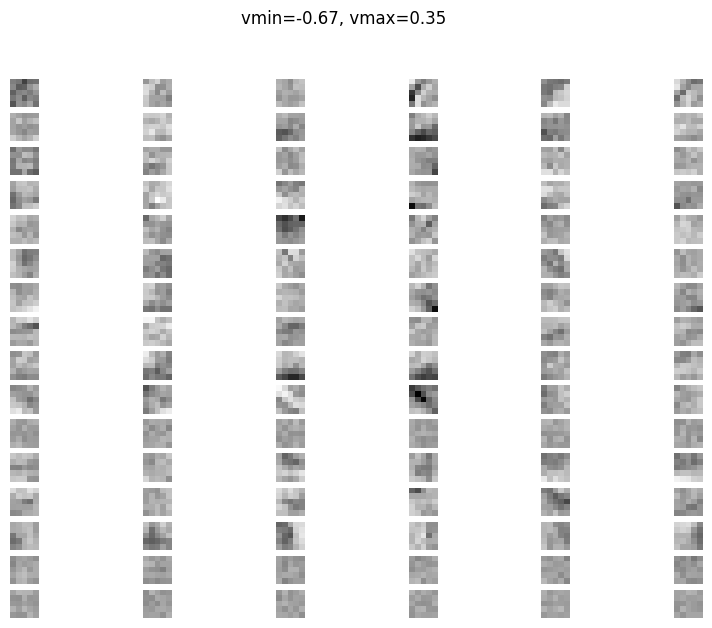

In [18]:
importlib.reload(lib)
import matplotlib.pyplot as plt

it = iter(net.parameters())
conv1 = next(it).data.numpy()
next(it)
conv2 = next(it).data.numpy()
lib.visual_utils.show_convs(conv2)



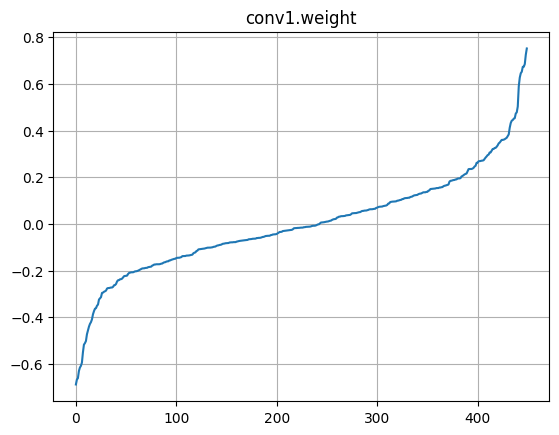

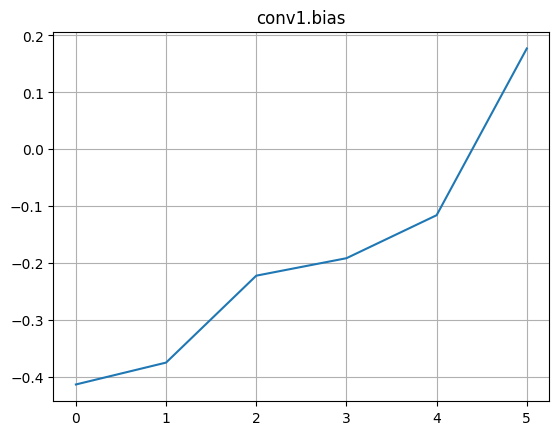

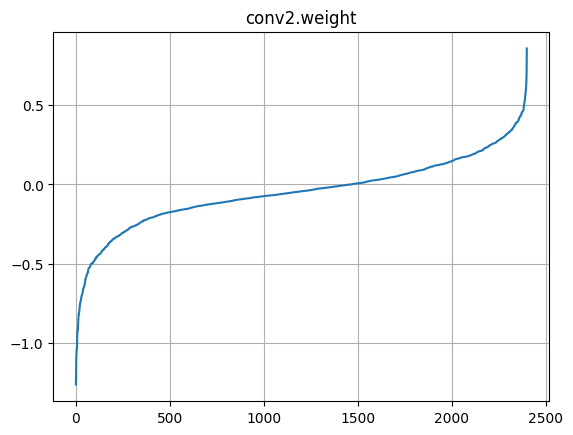

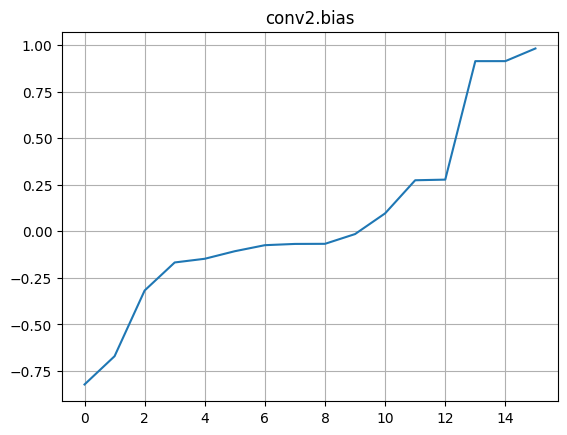

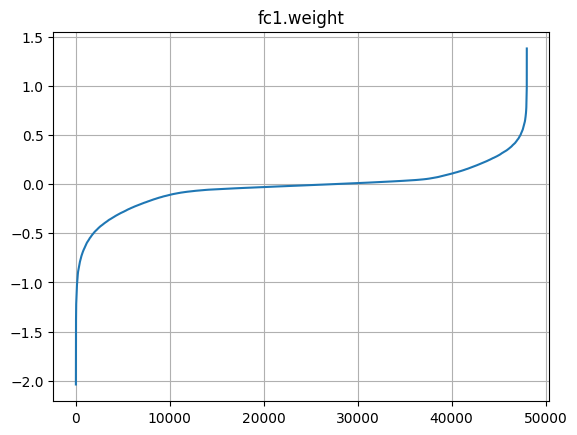

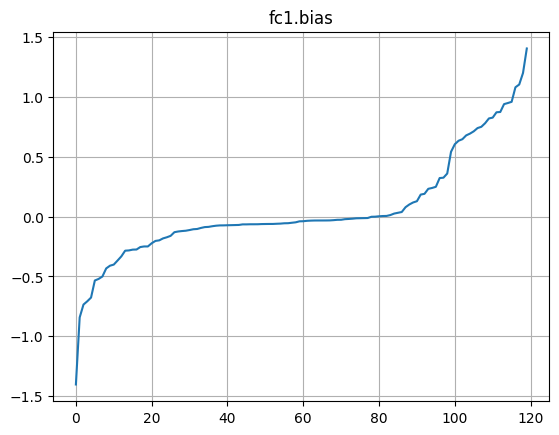

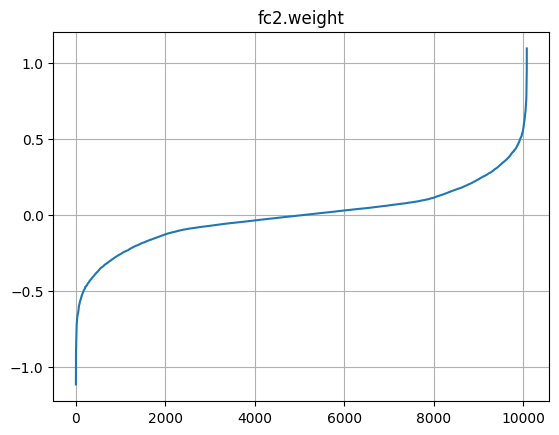

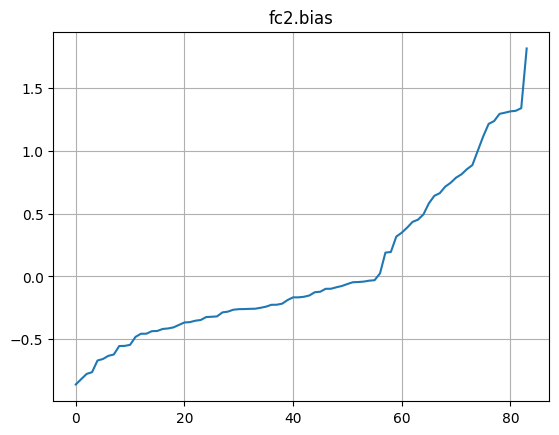

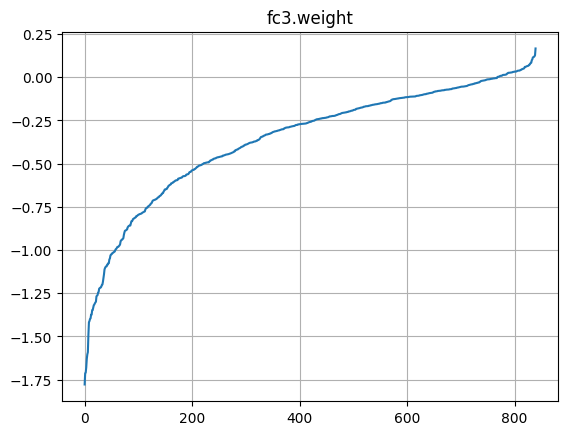

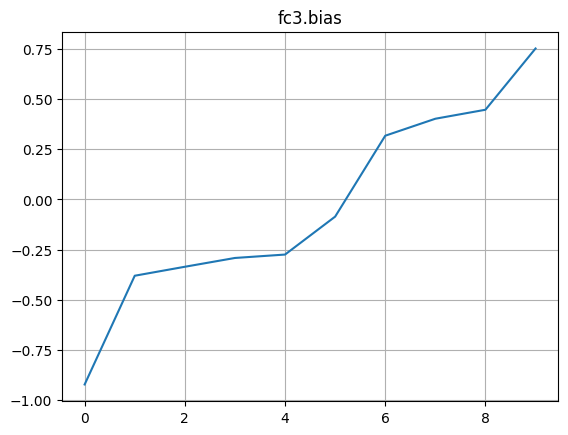

In [26]:
importlib.reload(lib)
stat = lib.stat_utils.AccumStat()
for name, param in net.named_parameters():
    stat = lib.stat_utils.AccumStat(param.data)
    stat.plot(name)


